In [1]:
import cudaq

@cudaq.kernel
def kernel():
    '''
    This is our first CUDA-Q kernel.
    '''
    # Next, we can allocate a single qubit to the kernel via `qubit()`.
    qubit = cudaq.qubit()

    # Now we can begin adding instructions to apply to this qubit!
    # Here we'll just add every non-parameterized
    # single qubit gate that is supported by CUDA-Q.
    h(qubit)
    x(qubit)
    y(qubit)
    z(qubit)
    t(qubit)
    s(qubit)

    # Next, we add a measurement to the kernel so that we can sample
    # the measurement results on our simulator!
    mz(qubit)


# Finally, we can execute this kernel on the state vector simulator
# by calling `cudaq.sample`. This will execute the provided kernel
# `shots_count` number of times and return the sampled distribution
# as a `cudaq.SampleResult` dictionary.
result = cudaq.sample(kernel)

# Now let's take a look at the `SampleResult` we've gotten back!
print(result)

{ 0:513 1:487 }



## Initializing states
It is often helpful to define an initial state for a kernel. There are a few ways to do this in CUDA-Q. Note, method 5 is particularly useful for cases where the state of one kernel is passed into a second kernel to prepare its initial state.
1. Passing complex vectors as parameters
2. Capturing complex vectors
3. Precision-agnostic API
4. Define as CUDA-Q amplitudes
5. Pass in a state from another kernel



In [2]:
# Capturing complex vectors
c = [0.70710678 + 0j, 0., 0., 0.70710678]

@cudaq.kernel
def kernel():
    q = cudaq.qvector(c)

result = cudaq.sample(kernel)
print(result)

{ 00:490 11:510 }



In [3]:
# Precision-Agnostic API
import numpy as np

c = np.array([0.70710678 + 0j, 0., 0., 0.70710678], dtype=cudaq.complex())


@cudaq.kernel
def kernel():
    q = cudaq.qvector(c)

result = cudaq.sample(kernel)
print(result)

{ 00:490 11:510 }



# Quantum Gates

#### Pauli X Gate
This gate flips the input from 0 to 1 and 1 to 0

In [4]:
@cudaq.kernel
def kernel():
    # A single qubit initialized to the ground / zero state.
    qubit = cudaq.qubit()

    # Apply the Pauli x gate to the qubit.
    x(qubit)

    # Measurement operator.
    mz(qubit)

# visualize the circuit
print(cudaq.draw(kernel))
# Sample the qubit for 1000 shots to gather statistics.
result = cudaq.sample(kernel)
print(result)
print(result.most_probable())



     ╭───╮
q0 : ┤ x ├
     ╰───╯

{ 1:1000 }

1


### Hadamard gate
The Hadamard gate allows us to put the qubit in an equal superposition state: |0> to |+> and |1> to |->


In [5]:
@cudaq.kernel
def kernel():
    # A single qubit initialized to the ground/ zero state.
    qubit = cudaq.qubit()

    # Apply Hadamard gate to single qubit to put it in equal superposition.
    h(qubit)

    # Measurement operator.
    mz(qubit)


print(cudaq.draw(kernel))
result = cudaq.sample(kernel)
print(result)
print("Measured |0> with probability " +
      str(result["0"] / sum(result.values())))
print("Measured |1> with probability " +
      str(result["1"] / sum(result.values())))



     ╭───╮
q0 : ┤ h ├
     ╰───╯

{ 0:498 1:502 }

Measured |0> with probability 0.498
Measured |1> with probability 0.502


In [6]:
@cudaq.kernel
def kernel():
    # 2 qubits both initialized to the ground/ zero state.
    qvector = cudaq.qvector(2)

    x(qvector[0])

    # Controlled-not gate operation.
    x.ctrl(qvector[0], qvector[1])

    mz(qvector[0])
    mz(qvector[1])

print(cudaq.draw(kernel))
result = cudaq.sample(kernel)
print(result)

     ╭───╮     
q0 : ┤ x ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

{ 11:1000 }



## Measurement

### Basic Measurement

Kernel measurement can be specified in the Z, X, or Y basis using mz, mx, and my. If a measurement is specified with no argument, the entire kernel is measured in that basis. Measurement occurs in the Z basis by default.


In [7]:
@cudaq.kernel
def kernel():
    qubits = cudaq.qvector(2)
    mz()

print(cudaq.sample(kernel))

{ 00:1000 }



Specific qubits or registers can be measured rather than the entire kernel.



In [8]:
@cudaq.kernel
def kernel():
    qubits_a = cudaq.qvector(2)
    qubit_b = cudaq.qubit()
    mz(qubits_a)
    mx(qubit_b)

print(cudaq.sample(kernel))

{ 0:506 1:494 }



### Mid circuit measurement

In certain cases, it it is helpful for some operations in a quantum kernel to depend on measurement results following previous operations. This is accomplished in the following example by performing a Hadamard on qubit 0, then measuring qubit 0 and savig the result as b0. Then, an if statement performs a Hadamard on qubit 1 only if b0 is 1. Measuring this qubit 1 verifies this process as a 1 is the result 25% of the time.

In [9]:
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)
    h(q[0])
    b0 = mz(q[0])
    if b0:
        h(q[1])
        mz(q[1])

print(cudaq.sample(kernel))

{ 
  __global__ : { 0:251 00:515 1:234 }
   b0 : { 0:515 1:485 }
}



## Visualizing kernels

Note: CUDA-Q uses the QuTiP library to render Bloch spheres. The following code will throw an error if QuTiP is not installed.

In [10]:
import sys

try:
    import matplotlib.pyplot as plt
    import qutip

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    print("\nNew libraries have been installed. Please restart your kernel!")


In [11]:
import cudaq
import numpy as np

@cudaq.kernel
def kernel(angles: np.ndarray):
    qubit = cudaq.qubit()
    rz(angles[0], qubit)
    rx(angles[1], qubit)
    rz(angles[2], qubit)

# Next, we instantiate a random number generator, so we can get random
# outputs. We then create 4 random single-qubit states by using
# cudaq.add_to_bloch_sphere() on the output state obtained from 
# the random kernel.

rng = np.random.default_rng(seed=11)
blochSphereList = []
for _ in range(4):
    angleList = rng.random(3) * 2 * np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel, angleList))
    blochSphereList.append(sph)


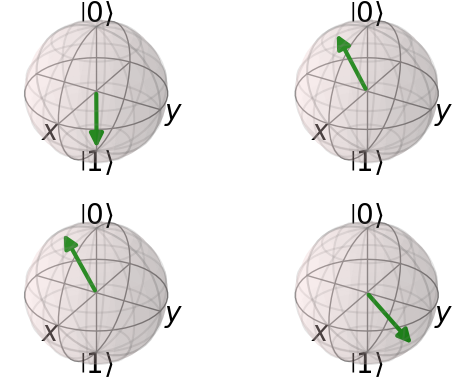

In [13]:
cudaq.show(blochSphereList[:], nrows=2, ncols=2)

What if we had to add multiple vectors to a single Bloch sphere? CUDA-Q uses the QuTiP toolbox to construct Bloch spheres. We can then add multiple states to the same Bloch sphere by passing the sphere object as an argument to cudaq.add_to_bloch_sphere().

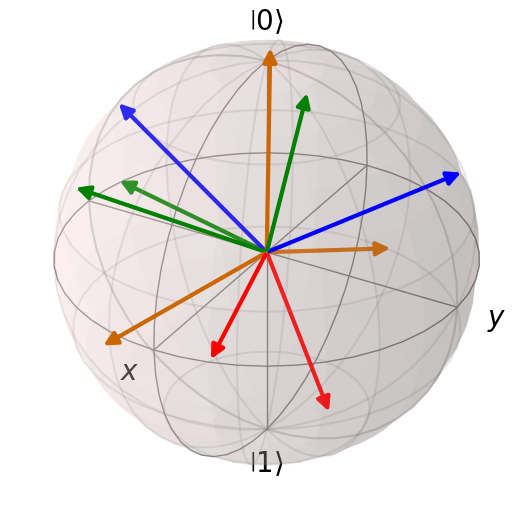

In [14]:
import qutip

rng = np.random.default_rng(seed=47)
blochSphere = qutip.Bloch()
for _ in range(10):
    angleList = rng.random(3) * 2 * np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel, angleList), blochSphere)

blochSphere.show()

## Kernel Visualization

In [17]:
@cudaq.kernel
def kernel_to_draw():
    q = cudaq.qvector(4)
    h(q)
    x.ctrl(q[0], q[1])
    y.ctrl([q[0], q[1]], q[2])
    z(q[2])

    swap(q[0], q[1])
    swap(q[0], q[3])
    swap(q[1], q[2])

    r1(3.14159, q[0])
    tdg(q[1])
    s(q[2])
    

print(cudaq.draw(kernel_to_draw))
print(cudaq.draw('latex', kernel_to_draw))

     ╭───╮                  ╭───────────╮       
q0 : ┤ h ├──●────●────╳───╳─┤ r1(3.142) ├───────
     ├───┤╭─┴─╮  │    │   │ ╰───────────╯╭─────╮
q1 : ┤ h ├┤ x ├──●────╳───┼───────╳──────┤ tdg ├
     ├───┤╰───╯╭─┴─╮╭───╮ │       │      ╰┬───┬╯
q2 : ┤ h ├─────┤ y ├┤ z ├─┼───────╳───────┤ s ├─
     ├───┤     ╰───╯╰───╯ │               ╰───╯ 
q3 : ┤ h ├────────────────╳─────────────────────
     ╰───╯                                      

\documentclass{minimal}
\usepackage{quantikz}
\begin{document}
\begin{quantikz}
  \lstick{$q_0$} & \gate{H} & \ctrl{1} & \ctrl{2} & \swap{1} & \swap{3} & \gate{R_1(3.142)} & \qw & \qw \\
  \lstick{$q_1$} & \gate{H} & \gate{X} & \ctrl{1} & \targX{} & \qw & \swap{1} & \gate{T^\dag} & \qw \\
  \lstick{$q_2$} & \gate{H} & \qw & \gate{Y} & \gate{Z} & \qw & \targX{} & \gate{S} & \qw \\
  \lstick{$q_3$} & \gate{H} & \qw & \qw & \qw & \targX{} & \qw & \qw & \qw \\
\end{quantikz}
\end{document}



In [31]:
@cudaq.kernel
def kernel_to_draw():
    q = cudaq.qvector(4)
    # H to the first qbit
    h(q[0])
    x.ctrl(q[0], q[1])
    y.ctrl([q[0], q[1]], q[2])
    y.ctrl(q[0], q[2])
    z(q[2])

    # This operation is an arbitrary rotation about the |1> state.
    r1(3.14159, q[0])

    # rx: This operation is an arbitrary rotation about the X axis.
    rx(3.14159, q[1])
    tdg(q[1])
    s(q[2])
    
print(cudaq.draw(kernel_to_draw))


     ╭───╮               ╭───────────╮       
q0 : ┤ h ├──●────●────●──┤ r1(3.142) ├───────
     ╰───╯╭─┴─╮  │    │  ├───────────┤╭─────╮
q1 : ─────┤ x ├──●────┼──┤ rx(3.142) ├┤ tdg ├
          ╰───╯╭─┴─╮╭─┴─╮╰───┬───┬───╯╰┬───┬╯
q2 : ──────────┤ y ├┤ y ├────┤ z ├─────┤ s ├─
               ╰───╯╰───╯    ╰───╯     ╰───╯ 



## Custom operatation

#### Example: Create a bell state. 

In [34]:
# Create and test a custom CNOT operation.
cudaq.register_operation(
    "my_cnot",
    np.array([1, 0, 0, 0,
              0, 1, 0, 0,
              0, 0, 0, 1,
              0, 0, 1, 0])
    )
    
@cudaq.kernel
def bell_pair():
    qubits = cudaq.qvector(2)
    h(qubits[0])
    my_cnot(qubits[0], qubits[1]) # `my_cnot(control, target)`
    
print(cudaq.draw(bell_pair))

cudaq.sample(bell_pair).dump() # prints { 11:500 00:500 } (exact numbers will be random)



     ╭───╮╭─────────╮
q0 : ┤ h ├┤         ├
     ╰───╯│ my_cnot │
q1 : ─────┤         ├
          ╰─────────╯

{ 00:486 11:514 }


In [35]:
# Construct a custom unitary matrix for X on the first qubit and Y
# on the second qubit.
X = np.array([[0,  1 ], [1 , 0]])
Y = np.array([[0, -1j], [1j, 0]])
XY = np.kron(X, Y)

# Register the custom operation
cudaq.register_operation("my_XY", XY)

@cudaq.kernel
def custom_xy_test():
    qubits = cudaq.qvector(2)
    my_XY(qubits[0], qubits[1])
    y(qubits[1]) # undo the prior Y gate on qubit 1

print(cudaq.draw(custom_xy_test))
cudaq.sample(custom_xy_test).dump() # prints { 10:1000 }

     ╭───────╮     
q0 : ┤       ├─────
     │ my_XY │╭───╮
q1 : ┤       ├┤ y ├
     ╰───────╯╰───╯

{ 10:1000 }


## Execute a quantum circuit

Quantum states collapse upon measurement and hence need to be sampled many times to gather statistics. The CUDA-Q sample call enables this:

In [44]:
import cudaq
import numpy as np

qubit_count = 2

# Define the simulation target.
num_gpus = cudaq.num_available_gpus()
if num_gpus > 1:
    cudaq.set_target("nvidia", option="mqpu")
else:
    cudaq.set_target("qpp-cpu")

# Define a quantum kernel function.

@cudaq.kernel
def kernel(qubit_count: int):
    qvector = cudaq.qvector(qubit_count)

    # 2-qubit GHZ state.
    h(qvector[0])
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])

    # If we dont specify measurements, all qubits are measured in
    # the Z-basis by default or we can manually specify it also
    # mz(qvector)


print(cudaq.draw(kernel, qubit_count))

result = cudaq.sample(kernel, qubit_count, shots_count=1000000)
print(result)

print("most probale result", result.probability(result.most_probable()))

     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

{ 00:500451 11:499549 }

most probale result 0.500451


## Observe

The observe function allows us to calculate expectation values. We must supply a spin operator in the form of a Hamiltonian, H, from which we would like to calculate .

In [41]:
from cudaq import spin

# Define a Hamiltonian in terms of Pauli Spin operators.
hamiltonian = spin.z(0) + spin.y(1) + spin.x(0) * spin.z(0)

# Compute the expectation value given the state prepared by the kernel.
result = cudaq.observe(kernel, hamiltonian, qubit_count).expectation()

print('<H> =', result)

<H> = 0.0


## Get states

The get_state function gives us access to the quantum statevector of the computation. Remember, that this is <b>only feasible in simulation mode.</b>

In [45]:
result = cudaq.get_state(kernel, qubit_count)

print(np.array(result))

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
